## Import

In [1]:
from mlprimitives.custom.timeseries_preprocessing import time_segments_aggregate
from mlprimitives.custom.timeseries_preprocessing import rolling_window_sequences
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from notebooks.tulog.model import hyperparameters
from orion.primitives.tadgan import TadGAN
from orion.data import load_signal, load_anomalies
from orion import Orion
from notebooks.tulog.utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

import matplotlib.pyplot as plt
import numpy as np
import warnings
import os

warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


## Load data

In [2]:
signal = 'nyc_taxi'
df = load_signal(signal)
known_anomalies = load_anomalies(signal)

In [3]:
df.head(5)

,timestamp,value
0,1404165600,10844.0
1,1404167400,8127.0
2,1404169200,6210.0
3,1404171000,4656.0
4,1404172800,3820.0


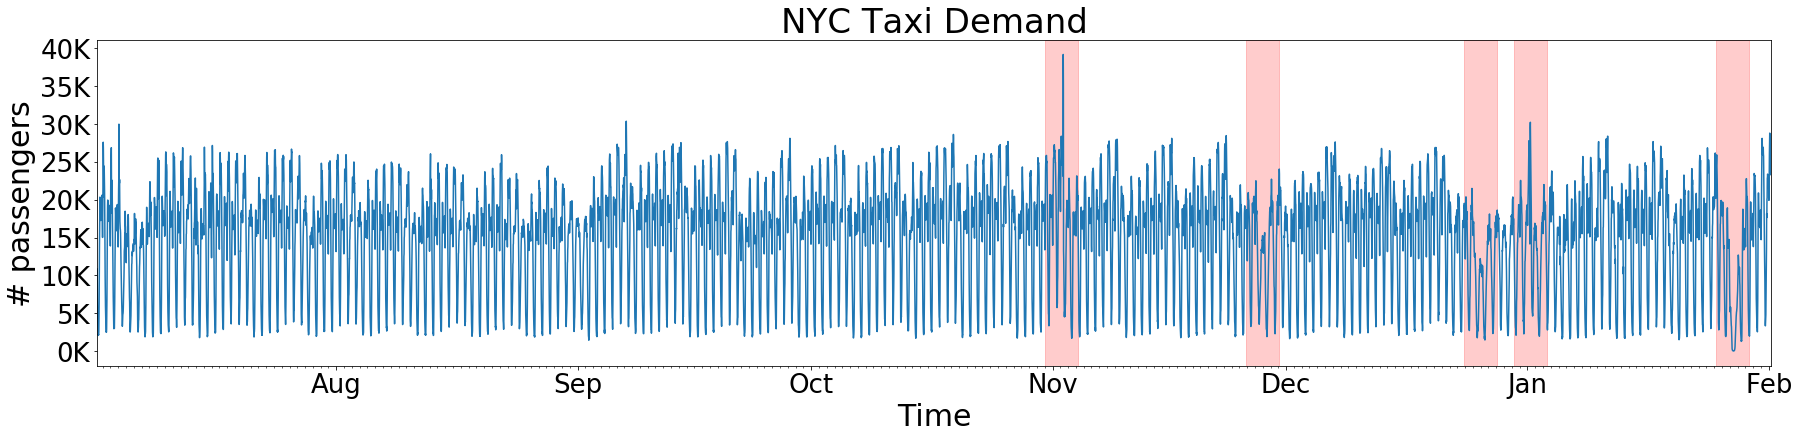

In [4]:
plot(df, known_anomalies)

## Modeling

* using json file

In [5]:
json_path = './orion/pipelines/verified/tadgan/'

In [14]:
orion = Orion(pipeline=json_path+'tadgan.json')

In [15]:
# fit the pipeline on the data then detect anomalies
anomalies = orion.fit_detect(df)

Epoch: 1/35, [Dx loss: [ 6.006809   -0.2995578   0.01954431  0.6286822 ]] [Dz loss: [1.9510142  0.2930374  0.04177501 0.1616202 ]] [G loss: [ 2.093956   -0.03933236 -0.04946125  0.21827497]]
Epoch: 2/35, [Dx loss: [-1.1182228  -3.540804    0.29373205  0.2128849 ]] [Dz loss: [ 0.8456212  -0.0443722   0.5126852   0.03773082]] [G loss: [ 1.2369175  -0.33971623 -0.5709162   0.214755  ]]
Epoch: 3/35, [Dx loss: [-2.9892242  -3.8652642   0.49305335  0.03829864]] [Dz loss: [ 1.5902836  -0.36244613  1.6880461   0.02646837]] [G loss: [ 0.16641432 -0.49649334 -1.4677782   0.21306857]]
Epoch: 4/35, [Dx loss: [-3.3131404  -4.972349    0.9407463   0.07184628]] [Dz loss: [ 2.4527647  -0.81796646  2.8654518   0.04052788]] [G loss: [-0.606882   -0.7682077  -2.3282704   0.24895962]]
Epoch: 5/35, [Dx loss: [-3.4889145  -4.6241183   0.6682603   0.04669441]] [Dz loss: [ 2.4266841  -1.1959401   2.8021924   0.08204315]] [G loss: [ 1.3039511  -0.69936347 -1.0161146   0.3019429 ]]
Epoch: 6/35, [Dx loss: [-3.80

In [16]:
anomalies.head(5)

,start,end,severity
0,1418529600,1420711200,0.100168


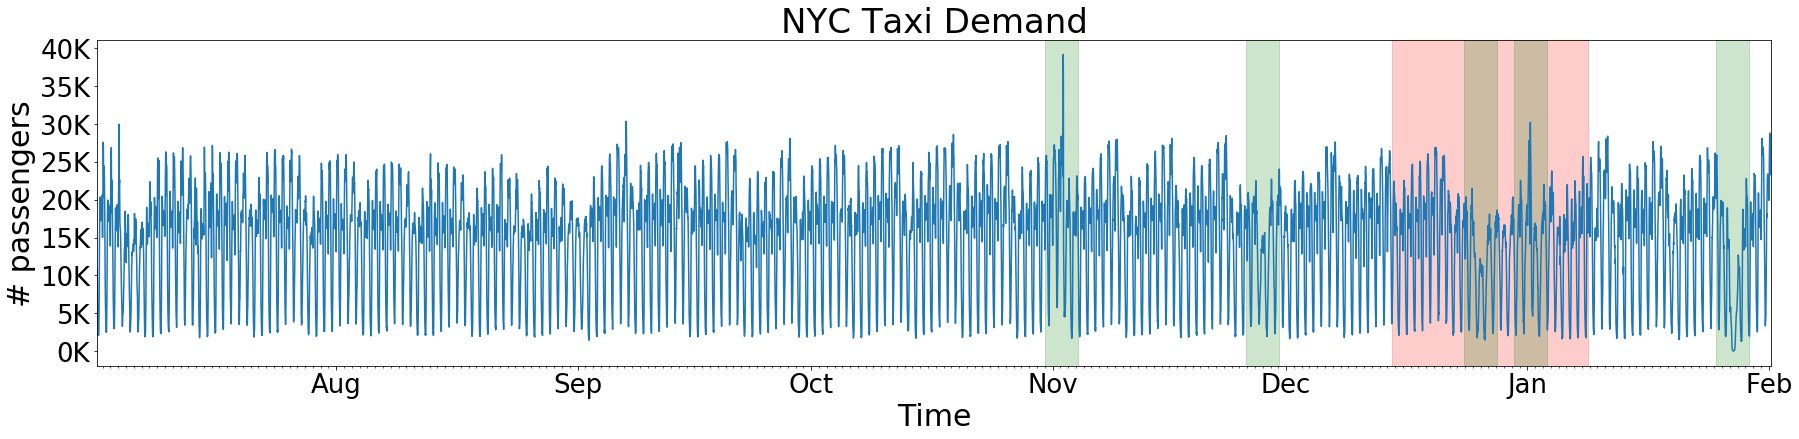

In [25]:
plot(df, [anomalies, known_anomalies])

* data preprocessing

In [5]:
# equalize steps (decide on a frequency)
X, index = time_segments_aggregate(df, 
                                   interval=1800, 
                                   time_column='timestamp',  
                                   method=['mean'])

# impute missing values
imp = SimpleImputer()
X = imp.fit_transform(X)

# scale the data between [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

* modeling

In [6]:
X, X_index, y, y_index = rolling_window_sequences(X, index, window_size=100, target_size=1, step_size=1,target_column=0)

print("Training data input shape: {}".format(X.shape))

Training data input shape: (10222, 100, 1)


In [7]:
hyperparameters["epochs"] = 100
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch: 1/100, [Dx loss: [-0.60295403 -3.0713167   1.6284759   0.0839886 ]] [Dz loss: [-1.2381959  -1.0158697  -1.6074198   0.13850947]] [G loss: [ 2.6127563 -1.6149186  2.7015054  0.1526169]]
Epoch: 2/100, [Dx loss: [-0.83006227 -4.4980135   3.5157285   0.0152224 ]] [Dz loss: [-2.9553914 -1.3956124 -2.8890908  0.1329311]] [G loss: [ 1.5777005  -3.4366436   3.716375    0.12979689]]
Epoch: 3/100, [Dx loss: [-0.49658966 -7.290282    6.6421876   0.01515021]] [Dz loss: [-1.028762   -0.991713   -0.52725554  0.0490207 ]] [G loss: [-4.7527013  -6.6128216   0.7642762   0.10958438]]
Epoch: 4/100, [Dx loss: [-0.36257523 -7.671046    7.1190467   0.0189431 ]] [Dz loss: [-0.8731413  -0.5940286  -0.68251705  0.04034044]] [G loss: [-4.4985943  -6.6008797   0.923383    0.11789031]]
Epoch: 5/100, [Dx loss: [-0.44696394  4.607909  

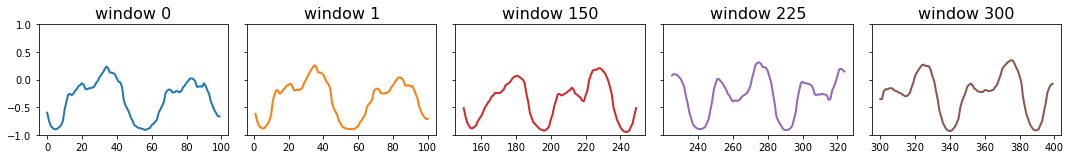

In [8]:
# reconstruct
X_hat, critic = tgan.predict(X)

# visualize X_hat
plot_rws(X_hat)

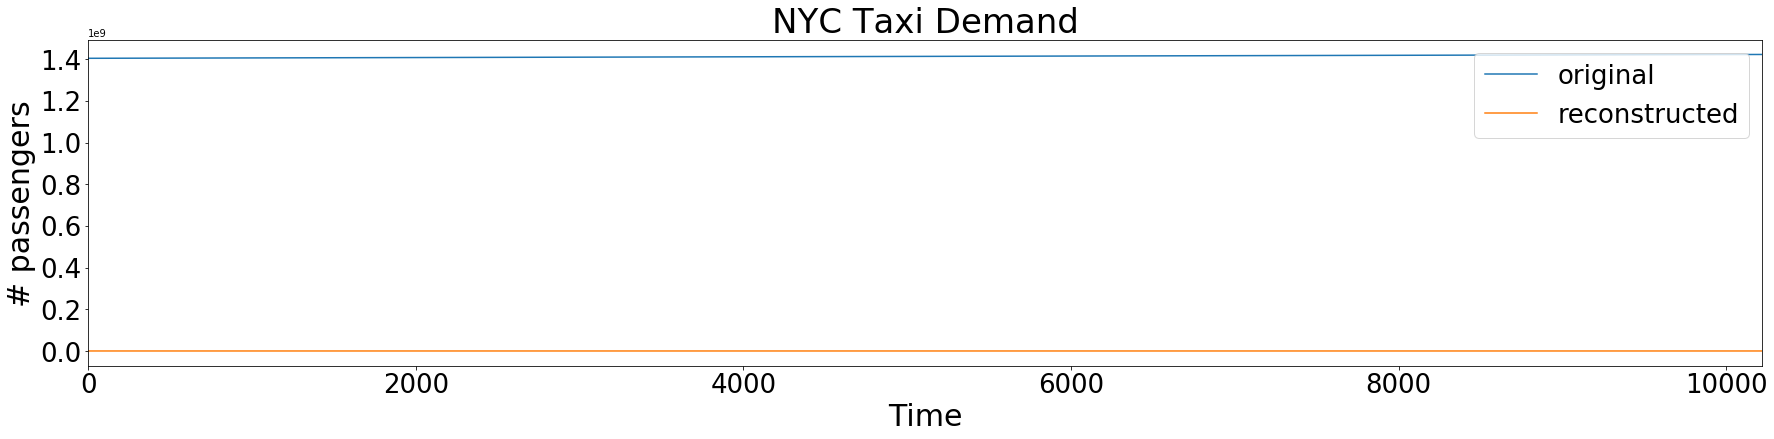

In [9]:
# flatten the predicted windows
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

* post-preprocessing

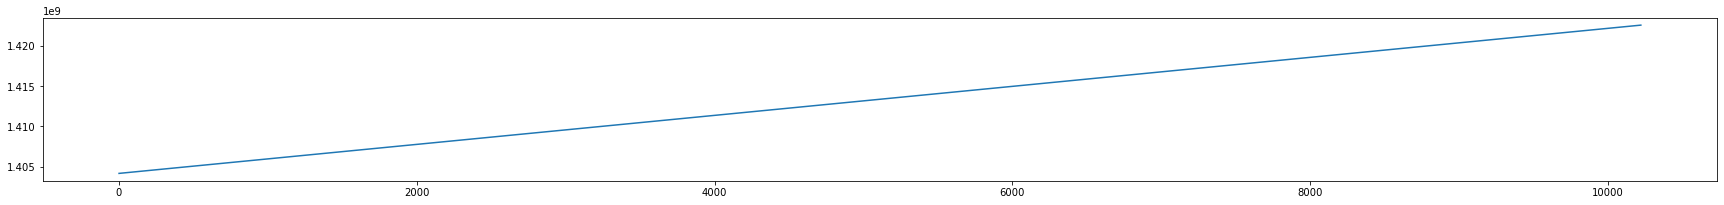

In [10]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

* raw

In [6]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp')

* imputation

In [7]:
imp = SimpleImputer()
X = imp.fit_transform(X)

* scaling

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [9]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

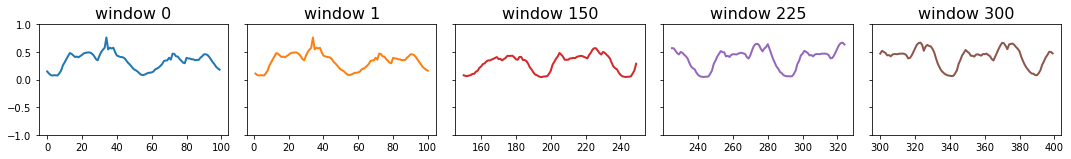

In [10]:
plot_rws(X)

* modeling

In [ ]:
hyperparameters["epochs"] = 100
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch: 1/100, [Dx loss: [ 0.05629101 -0.8588742  -0.05343828  0.09686035]] [Dz loss: [-2.525059   -0.6933342  -4.1404114   0.23086885]] [G loss: [7.4551687  0.16075978 5.8980174  0.13963917]]
Epoch: 2/100, [Dx loss: [-0.8977658  -1.4750137   0.30157673  0.02756712]] [Dz loss: [-3.3831418  -0.5859984  -3.6917508   0.08946085]] [G loss: [5.424979   0.20483866 4.512723   0.07074173]]
Epoch: 3/100, [Dx loss: [-0.5226567 -4.3787417  3.7223294  0.0133756]] [Dz loss: [-2.2639782  -0.76004547 -2.1186635   0.0614731 ]] [G loss: [-0.38768685 -3.6369653   2.5416186   0.07076591]]
Epoch: 4/100, [Dx loss: [-0.92870516  4.4090714  -5.471139    0.01333645]] [Dz loss: [-2.4072845  -1.1996374  -1.7274237   0.05197761]] [G loss: [8.009771   5.4490776  2.147408   0.04132874]]
Epoch: 5/100, [Dx loss: [-0.37126476 -6.603754    6.1570

In [ ]:
# flatten the predicted windows
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

In [ ]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

In [ ]:
from orion.primitives.tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

In [ ]:
# threshold
thresh = 10

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

In [ ]:
import pandas as pd
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

* 참고: https://ichi.pro/ko/sigyeyeol-isang-tamji-dib-leoning-sidae-264035144704586